## Wordle Opener Analysis from Tweets

Wordle tweet data is a useful data source and can, for example, [accurately predict](https://twitter.com/thewordlebot/status/1498661373626265600) the wordle solution for the day, as is demonstrated by other code in this repository. Analyzing the popularity of wordle openers is a little harder, since on any given day all we know are the most popular opening patterns. e.g. 🟨🟩⬜⬜⬜.

TDLR; the most common openers based on a linear regression analysis are:

* adieu
* audio
* crane
* train
* stare
* arise
* great
* heart
* arose
* raise

### Load and prep the data
Most of the functionality used is in the files `first_word.py`. The function `make_first_guess_list` creates a useful dataframe for analysis.

I start with the excellent kaggle data set [wordle-tweets](https://www.kaggle.com/benhamner/wordle-tweets) and extract directly from the zipfile which I download with the [kaggle api](https://github.com/Kaggle/kaggle-api). The `get_first_words` function processes the dataframe:

    1. It removes tweeted scores that contain an invalid score line for that answer (likely played on a cached version of the puzzle, not the live one on the NY Times site).
    2. It removes any tweets that have more than 6 score patterns.
    3. It extracts the first pattern from the tweeted scores.
    4. It maps on the answer for a given wordle id.
    5. It groups by the answer for the day, and creates a dataframe that has score, target, guess, and some data on how popular that score is.

In [1]:
from first_word import make_first_guest_list
df = make_first_guest_list()

Max wordle num 257
Filtered out 12580 of 277615 rows


In [2]:
df

,score,target,guess,score_frequency_rank,score_count_fraction,wordle_num,guess_count,commonality,weighted_rank
0,20100,aloft,aalii,62.0,0.001330,231,38,0,3844.0
1,20000,aloft,aargh,3.0,0.071685,231,325,71592,9.0
2,20010,aloft,aarti,19.0,0.013832,231,88,63273,361.0
3,20000,aloft,abaca,3.0,0.071685,231,325,79841,9.0
4,20000,aloft,abaci,3.0,0.071685,231,325,0,9.0
...,...,...,...,...,...,...,...,...,...
12940,01000,wrung,zuzim,7.0,0.050536,225,852,0,49.0
12941,00100,wrung,zygal,5.0,0.069694,225,1461,0,25.0
12942,00101,wrung,zygon,11.0,0.017046,225,153,15300,121.0
12943,00000,wrung,zymes,1.0,0.173631,225,4320,24137,1.0


### Simple analysis

We have a large dataframe of almost 600,000 columns. One row for every pattern and every guess for every wordle answer. A simple way to look at common starter words would be to group by the guess and look which words consistently rank high across several days.

In [3]:
df.groupby('guess')['score_frequency_rank'].mean().sort_values().head(10)

guess
adieu    2.760417
braze    3.093750
graze    3.500000
jeeze    4.114583
feaze    4.166667
craze    4.208333
seaze    4.208333
brave    4.333333
jazzy    4.510417
ceaze    4.552083
Name: score_frequency_rank, dtype: float64

This analysis leaves a lot to be desired. While other evidence indicates `adieu` is a popular opener, it does not seem like `jazzy` would be one. Or for that matter, words with a `z`. 

The `00000` all grey pattern is fairly common, so words with uncommon letters will show up a lot since `00000` is common because of the sheer volume of words that can create the pattern. So what happens if we  filter out the null score? Not much...

In [4]:
df.query("score != '00000'").groupby('guess')['score_frequency_rank'].mean().sort_values().head(10)

guess
adieu    2.920455
braze    3.716216
graze    4.157895
craze    4.948718
brave    5.210526
trave    5.426829
grate    5.524390
audio    5.585106
frize    5.587500
grave    5.602564
Name: score_frequency_rank, dtype: float64

So are people guessing `braze` first regularly or is something else going on? BRAZE's score line is common but what other words could make the same patern?

In [5]:
df.query('score == "00101" and wordle_num == 230').sort_values('commonality',ascending=False).head(10)

,score,target,guess,score_frequency_rank,score_count_fraction,wordle_num,guess_count,commonality,weighted_rank
5315,00101,pleat,image,9.0,0.029706,230,186,197874283,81.0
9847,00101,pleat,share,9.0,0.029706,230,186,119294241,81.0
11916,00101,pleat,until,9.0,0.029706,230,186,113090086,81.0
4576,00101,pleat,grade,9.0,0.029706,230,186,54275130,81.0
4011,00101,pleat,frame,9.0,0.029706,230,186,46079991,81.0
11974,00101,pleat,usage,9.0,0.029706,230,186,25440406,81.0
9850,00101,pleat,sharp,9.0,0.029706,230,186,24904199,81.0
4575,00101,pleat,grace,9.0,0.029706,230,186,17642126,81.0
12119,00101,pleat,villa,9.0,0.029706,230,186,17587586,81.0
10389,00101,pleat,solve,9.0,0.029706,230,186,13452150,81.0


There are a lot of words that make the same pattern, is `BRAZE` popular or is it riding the coattails of some other `_RA_E` word?

### Linear Regression

A better approach is to control for the presence of other words, and look for an independent signal. If BRAZE only does well when it's paired with GRACE or GRADE or SHARE than a linear regression should isolate the guesses that actually are predictive of a popular score count line.

The difficulty comes from getting the dataframe into the right format, thankfully I discovered [pd.crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html), and there are [other methods that were all better](https://stackoverflow.com/questions/46791626/one-hot-encoding-multi-level-column-data) than what I had been doing originally (an awful groupby loop than took over a minute.)

In [6]:
df.rename(columns={'score': 'score_pattern'}, inplace=True)

one_hot_encoded_data = pd.crosstab(
    [df['wordle_num'], df['score_pattern']], df['guess']).join(
        df.groupby(['wordle_num',
                    'score_pattern'])[['score_count_fraction',
                                       'guess_count']].first()).reset_index()


In [7]:
one_hot_encoded_data

,aalii,aargh,aarti,abaca,abaci,aback,abacs,abaft,abaka,abamp,...,zuppa,zurfs,zuzim,zygal,zygon,zymes,zymic,wordle_num,score_count_fraction,guess_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,210.0,0.099927,2760.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,210.0,0.015430,401.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,NaN,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,210.0,0.092212,736.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.002939,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,NaN,1.0
6635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,NaN,2.0
6636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,NaN,2.0
6637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.000298,2.0


Now we'll sort of normalize the data a little and then fit a model. We use a [Ridge](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification) which helps control the size of the coefficients.

In [9]:
one_hot_encoded_data.dropna(subset=['score_count_fraction'],inplace=True) #don't need patterns no one actually guessed

std = one_hot_encoded_data['score_count_fraction'].std()
one_hot_encoded_data['score_count_fraction'] = (one_hot_encoded_data[
    'score_count_fraction'] - one_hot_encoded_data['score_count_fraction'].mean()) / std

one_hot_encoded_data['guess_count'] = (one_hot_encoded_data[
    'guess_count'] - one_hot_encoded_data['guess_count'].mean()) / one_hot_encoded_data[
    'guess_count'].std()

In [68]:
from sklearn import linear_model
data = one_hot_encoded_data 
X= data.drop(
        columns=[ 'score_count_fraction', 'wordle_num','score_pattern']) # fit to the one hot encouded guesses and the total guess count
y=data['score_count_fraction'] # our dependent is the fraction of guesses that had the score pattern

r = linear_model.Ridge(alpha=10,fit_intercept=True)
r.fit(X,y)



Ridge(alpha=10)

#### Results!

Now we can just look at the coefficients of the variables to see which ones most strongly predict a popular pattern. The top few guesses contain some [expected and unexpected](https://yougov.co.uk/topics/entertainment/articles-reports/2022/02/03/wordle-starter-words-hard-mode-and-x6-how-are-brit) entries. _(Note: that survey was only of British wordle players)_

In [69]:
pd.DataFrame(list(zip(r.coef_, r.feature_names_in_)),
         columns=['coef', 'variable']).sort_values('coef',ascending=False).head(15)

,coef,variable
108,0.462831,adieu
633,0.261768,audio
10645,0.185984,stare
2362,0.183343,crane
531,0.178913,arise
11564,0.170128,train
4926,0.161756,heart
4602,0.161709,great
547,0.152424,arose
2371,0.146164,crate


### CRANE

On February 6, 3Blue1Brown released a video positing that [CRANE was the best opener](https://www.youtube.com/watch?v=v68zYyaEmEA). Though this was later [recanted](https://www.youtube.com/watch?v=fRed0Xmc2Wg), it generated plenty of [media](https://kotaku.com/wordle-starting-word-math-science-bot-algorithm-crane-p-1848496404) [coverage](https://www.forbes.com/sites/paultassi/2022/02/08/the-best-wordle-starter-word-a-first-guess-through-science/?sh=94c150a27909). CRANE was #5 on my list, how does it look before and after the video?

In [70]:
data_recent = one_hot_encoded_data.query('wordle_num > 232')
X= data_recent.drop(
        columns=[ 'score_count_fraction', 'wordle_num']) # fit to the one hot encouded guesses and the total guess count
y=data_recent['score_count_fraction'] # our dependent is the fraction of guesses that had the score pattern

r = linear_model.Ridge(alpha=10)
r.fit(X,y)



Ridge(alpha=10)

In [71]:
pd.DataFrame(list(zip(r.coef_, r.feature_names_in_)),
         columns=['coef', 'variable']).sort_values('coef',ascending=False).head(5)

,coef,variable
109,0.317424,adieu
2363,0.212652,crane
634,0.208788,audio
10646,0.162809,stare
2372,0.161388,crate


Hello there, CRANE jumps to the second spot! What about before wordle 233?

In [72]:
data_past = one_hot_encoded_data.query('wordle_num <= 232')
X= data_past.drop(
        columns=[ 'score_count_fraction', 'wordle_num']) # fit to the one hot encouded guesses and the total guess count
y=data_past['score_count_fraction'] # our dependent is the fraction of guesses that had the score pattern

r = linear_model.Ridge(alpha=10)
r.fit(X,y)




out = pd.DataFrame(list(zip(r.coef_, r.feature_names_in_)),
         columns=['coef', 'variable']).sort_values('coef',ascending=False)
out['guess_rank'] = out['coef'].rank(ascending=False)
out.query('variable == "crane"')

Ridge(alpha=10)

,coef,variable,guess_rank
2363,0.014525,crane,1018.0


Prior to Wordle 233, CRANE ranked 1018! Quite the turnaround. (Alpha values may not be optimal for these smaller sample sizes) You can see this even in the cruder analysis.

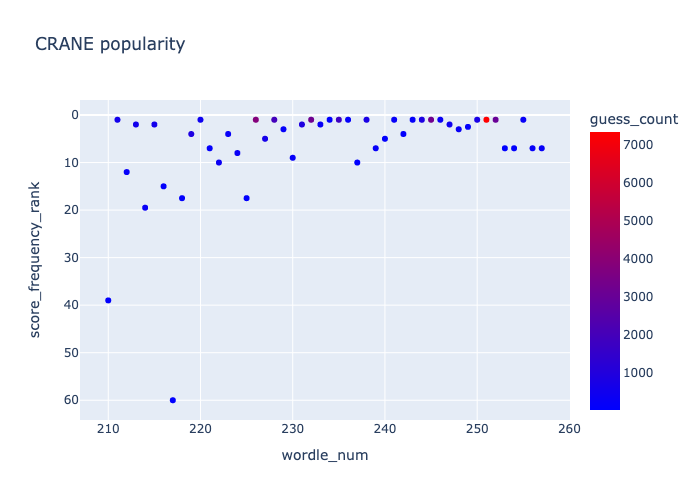

In [73]:
import plotly.io as pio;# plots should work with matplotlib backend too but ... plotly is better!
pio.renderers.default = "png" #here only for github, for plotly


guess = 'crane'
myplot = df.query(f'guess == @guess').sort_values(
    'wordle_num').plot.scatter(
        x='wordle_num',
        y='score_frequency_rank',
        color='guess_count',
        title=f'{guess.upper()} popularity',backend='plotly',
        color_continuous_scale='bluered',
    )
myplot.update_yaxes(autorange="reversed")